In [293]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [294]:
data_X = np.loadtxt('preprocessed_data/train_X.csv', delimiter=',')
data_y = np.loadtxt('preprocessed_data/train_y.csv', delimiter=',')

data_X, data_y = torch.from_numpy(data_X).float(), torch.from_numpy(data_y).long()

In [295]:
data_X.shape, data_y.shape

(torch.Size([780, 25]), torch.Size([780]))

In [296]:
n = int(len(data_X) * 0.8)

train_X, train_y = data_X[:n], data_y[:n]
val_X, val_y = data_X[n:], data_y[n:]

In [297]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape

(torch.Size([624, 25]),
 torch.Size([624]),
 torch.Size([156, 25]),
 torch.Size([156]))

In [298]:
batch_size = 64

def get_train_batch():
    ix = torch.randint(len(train_X), (batch_size,))
    x, y = train_X[ix], train_y[ix]
    return x, y

In [299]:
evals = 10
accs = []

def get_train_acc():
    model.eval()
    with torch.no_grad():
        xb, xy = get_train_batch()
        y_pred = model(xb)
        y_pred = torch.argmax(y_pred, dim=1)
        acc = (y_pred == xy).float().mean()
        accs.append(acc)
    model.train()
    return acc

In [300]:
def get_val_acc():
    model.eval()
    with torch.no_grad():
        y_pred = model(val_X)
        y_pred = torch.argmax(y_pred, dim=1)
        acc = (y_pred == val_y).float().mean()
    model.train()
    return acc

In [301]:
n_input = train_X.shape[1]
n_hidden = 32

model = nn.Sequential(
    nn.Linear(n_input, n_hidden),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, 2),
)

optimizer = torch.optim.AdamW(model.parameters())

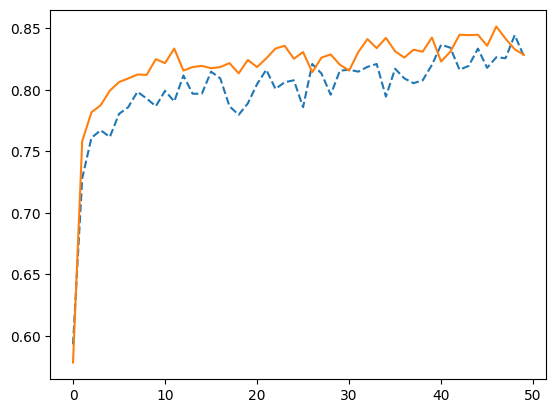

In [302]:
max_iters = 1000
eval_interval = 1

train_accs = []
val_accs = []

for i in range(max_iters):
        
    xb, yb = get_train_batch()
    
    loss = F.cross_entropy(model(xb), yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if i % eval_interval == 0:
        train_acc = get_train_acc()
        val_acc = get_val_acc()
        # print(f'step {i} | train loss {train_acc:.4f} | val accuracy {val_acc:.4f}')
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
plt.plot(torch.tensor(train_accs).view((-1, 20)).mean(dim=1), '--', label='train')
plt.plot(torch.tensor(val_accs).view((-1, 20)).mean(dim=1), '-', label='val')

In [303]:
test_data = np.loadtxt('preprocessed_data/test_X.csv', delimiter=',')
passenger_ids = np.loadtxt('preprocessed_data/passenger_ids.csv', delimiter=',')

test_data = torch.from_numpy(test_data).float()
passenger_ids = torch.from_numpy(passenger_ids).long()

test_data.shape, passenger_ids.shape

(torch.Size([418, 25]), torch.Size([418]))

In [1]:
# Make predictions
model.eval()
softmax = nn.Softmax(dim=1)
preds = softmax(model(test_data))
preds = torch.argmax(preds, dim=1)
final = torch.stack([passenger_ids, preds], dim=1)

# Save predictions to csv file
final_np = final.numpy()
df = pd.DataFrame(final_np, columns=['PassengerId', 'Survived'])
df.to_csv('submission_dl.csv', index=False)

NameError: name 'model' is not defined